# IBM Coursera Capstone
### Assignment #3/4 Canadian Diversity
##### Brett Wiens

### Introduction
As Canada heads towards an election, it is often described as a very regional defined country. The country is easily divided into distinct areas.  The maritimes, Quebec, Ontario, the prairie provinces, and British Columbia.  At the same time, despite being the second largest country in the world by area, it is an urbanized country with more than 80% of the population living in cities. Contrasting with the perception of a fragmented region-based country, cities are considered sterile and uniform. So which is it? If we compare amenities available to each of the major cities in Canada, will we determine that all cities are the same, or are there clusters of similar amenities in each FSA (forward sortation area) in each city that differentiates them from each other.  This assignment will attempt to use Python, foursquare, and a variety of cartographic and analytics approaches to answer that question.

In [1]:
## Importing the necessary libraries - I prefer to do this all at once so that I don't accidentally fill the code with 
## redundant lines later, or call the same library with different names.

import pandas as pd                 ## Import the pandas library as pd to be used later
import numpy as np                  ## Import the numpy library as np to be used later
import geopandas as gpd             ## Import the geopandas library (necessary for mapping)
from shapely.geometry import Point  ## The shapely point library allows points to be added to maps

import matplotlib.pyplot as plt     ## Import the pyplot library
from mpl_toolkits.axes_grid1 import make_axes_locatable

import urllib3                      ## My computer is behind a firewall, so I have to bypass security, this helps
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)  ## This means you don't have to read warnings

from sklearn.cluster import KMeans  ## import k-means for clustering stage

import matplotlib.cm as cm  
import matplotlib.colors as colors
from collections import Counter, defaultdict

plt.rcParams['figure.figsize'] = [20, 10]   ## I like my pictures to be big and readable... this does that

### Collecting Data

All of the postal codes (FSA) and a somewhat meaty list of community names are available through wikipedia. Frustratingly, Toronto (the sample demonstrated in the course material) is unique in its structure and format. Fortunately, every other province is consistent. Once the method for scraping was figured, it could be replicated.

- All FSA data is being scraped from wikipedia and processed using BeautifulSoup.
- Geographic information for FSAs can be obtained from Statistics Canada, the shapefile was downloaded from:
https://www150.statcan.gc.ca/n1/en/catalogue/92-179-X
- The FSA centroids were downloaded from geogratis: http://geogratis.gc.ca/services/geolocation/en/locate?q

### Procedure

All of the FSAs that correspond to one of Canada's major cities will be scraped from the wikipedia site. Conveniently, all major cities have some of the neighbourhoods in parentheses after the name. For example, "Calgary (Briar Hill, Capitol Hill, Hillhurst)." This makes for a convenient way to identify them without manually delineating each necessary FSA.  For this study, I will use Vancouver, Calgary, Edmonton, Winnipeg, Toronto, and Montreal.  A few of the other major cities (Ottawa and Quebec City) do not have the neighbourhood shortcut, so I've left them out of scope.

The FSA data will be combined with amenity data from foursquare for each FSA and further combined with the geographic centroids of each FSA courtesy of geogratis, and the polygon shapefile from statistics Canada. There is an abundance of sociodemographic data available from statistics canada as well, but we will leave this out. The amenity data will be what we use to determine the similarity or dissimilarity of various FSA in Canada's big cities.

The ten most common amenity types will be determined for each FSA, these will then be compared using K-means clustering to determine which communities are most similar or dissimilar, and whether different cities show different characteristics. This will be visualized cartographically using geopandas.  If different cities show a greater variety of amenity distributions than those within the same city, it will be determined that there are marked regional differences. If clustering is approximately the same between cities as within cities, then it will be determined that cities are in fact bland uniform melting pots.

In [2]:
## Getting Alberta Postal Codes and Neighbourhoods
import requests

websiteURL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T'
response = requests.get(websiteURL, verify=False)
html = response.text

from bs4 import BeautifulSoup                                       # Import the Beautiful Soup Package
soup = BeautifulSoup(html, "html.parser")                           # Parse the HTML from the website
WikiSourceTable = soup.find('table',{'rules':'all'})

CleanString=""                                 # Initialize a blank string
for tr in WikiSourceTable.find_all('tr'):      # Find all table rows (tr) from the source table
    row1=""                                    # Initialize a blank row (Important because it needs to be appended to)
    for tds in tr.find_all('td'):              # Find all table columns (td) from the source table within the current tr
        row1=row1+","+tds.text                 # Append to the current row the td values with a comma separator
    CleanString=CleanString+row1[1:]           # Append to the CleanString the current row with all columns
CleanString 

CleanString = CleanString.replace('\n',',')    # String has new line characters, replace them with commas
CleanList = CleanString.split(',')             # Split the string at the commas (making a list instead)

CleanList = list(filter(None, CleanList))
CopyList = CleanList

CleanList[:] = [x for x in CleanList if "(" in x]
AlbertaList = CleanList

ABList = ""
for FSA in AlbertaList:
    Before, After = FSA[:3],FSA[3:]
    ABList = ABList + "," + Before + "," + After

ABList = ABList.replace(")","")
ABList = ABList.replace("(",",")
ABList = ABList.split(',')             # Split the string at the commas (making a list instead)
ABList= list(filter(None, ABList))

CleanArray = np.array(ABList[0:213]).reshape(71,3)

Neighbourhoods = pd.DataFrame(data=CleanArray[0:,0:])      # Converts the array into a pandas dataframe (all rows, all columns)
Neighbourhoods.columns = ['FSA','City','Neighbourhood'] # Names the columns appropriately (FSA = Forward Sortation Area)
Alberta = Neighbourhoods

Alberta.FSA.unique()

array(['T2A', 'T3A', 'T5A', 'T6A', 'T2B', 'T3B', 'T5B', 'T6B', 'T2C',
       'T3C', 'T5C', 'T6C', 'T2E', 'T3E', 'T5E', 'T6E', 'T8E', 'T9E',
       'T2G', 'T3G', 'T5G', 'T6G', 'T2H', 'T3H', 'T5H', 'T6H', 'T2J',
       'T3J', 'T5J', 'T6J', 'T2K', 'T3K', 'T5K', 'T6K', 'T2L', 'T3L',
       'T5L', 'T6L', 'T2M', 'T3M', 'T5M', 'T2N', 'T5N', 'T6N', 'T2P',
       'T3P', 'T5P', 'T6P', 'T2R', 'T5R', 'T6R', 'T2S', 'T5S', 'T6S',
       'T2T', 'T5T', 'T6T', 'T2V', 'T5V', 'T6V', 'T2W', 'T5W', 'T6W',
       'T2X', 'T5X', 'T6X', 'T1Y', 'T2Y', 'T5Y', 'T2Z', 'T5Z'],
      dtype=object)

In [3]:
## Getting BC Postal Codes and Neighbourhoods
import requests

websiteURL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V'
response = requests.get(websiteURL, verify=False)
html = response.text

from bs4 import BeautifulSoup                                       # Import the Beautiful Soup Package
soup = BeautifulSoup(html, "html.parser")                           # Parse the HTML from the website
WikiSourceTable = soup.find('table',{'rules':'all'})

CleanString=""                                 # Initialize a blank string
for tr in WikiSourceTable.find_all('tr'):      # Find all table rows (tr) from the source table
    row1=""                                    # Initialize a blank row (Important because it needs to be appended to)
    for tds in tr.find_all('td'):              # Find all table columns (td) from the source table within the current tr
        row1=row1+","+tds.text                 # Append to the current row the td values with a comma separator
    CleanString=CleanString+row1[1:]           # Append to the CleanString the current row with all columns
CleanString 

CleanString = CleanString.replace('\n',',')    # String has new line characters, replace them with commas
CleanList = CleanString.split(',')             # Split the string at the commas (making a list instead)

CleanList = list(filter(None, CleanList))
CopyList = CleanList

CleanList[:] = [x for x in CleanList if "(" in x]
BritishColumbiaList = CleanList

BCList = ""
for FSA in BritishColumbiaList:
    Before, After = FSA[:3],FSA[3:]
    BCList = BCList + "," + Before + "," + After

BCList = BCList.replace(")","")
BCList = BCList.replace("(MARPAC"," / ")
BCList = BCList.replace("(",",")
BCList = BCList.split(',')             # Split the string at the commas (making a list instead)
BCList= list(filter(None, BCList))

CleanArray = np.array(BCList[0:208]).reshape(69,3)

Neighbourhoods = pd.DataFrame(data=CleanArray[0:,0:])      # Converts the array into a pandas dataframe (all rows, all columns)
Neighbourhoods.columns = ['FSA','City','Neighbourhood'] # Names the columns appropriately (FSA = Forward Sortation Area)
BC = Neighbourhoods

BC.FSA.unique()

array(['V3A', 'V5A', 'V6A', 'V9A', 'V5B', 'V6B', 'V7B', 'V9B', 'V5C',
       'V6C', 'V9C', 'V5E', 'V6E', 'V9E', 'V5G', 'V6G', 'V7G', 'V5H',
       'V6H', 'V7H', 'V5J', 'V6J', 'V7J', 'V5K', 'V6K', 'V7K', 'V5L',
       'V6L', 'V7L', 'V8L', 'V3M', 'V5M', 'V6M', 'V7M', 'V3N', 'V5N',
       'V6N', 'V7N', 'V8N', 'V5P', 'V6P', 'V7P', 'V8P', 'V5R', 'V6R',
       'V7R', 'V8R', 'V5S', 'V6S', 'V8S', 'V4T', 'V5T', 'V6T', 'V8T',
       'V9T', 'V5V', 'V8V', 'V5W', 'V8W', 'V5X', 'V7X', 'V8X', 'V9X',
       'V5Y', 'V7Y', 'V8Y', 'V5Z', 'V6Z', 'V8Z'], dtype=object)

In [4]:
## Getting MB Postal Codes and Neighbourhoods
import requests

websiteURL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_R'
response = requests.get(websiteURL, verify=False)
html = response.text

from bs4 import BeautifulSoup                                       # Import the Beautiful Soup Package
soup = BeautifulSoup(html, "html.parser")                           # Parse the HTML from the website
WikiSourceTable = soup.find('table',{'rules':'all'})

CleanString=""                                 # Initialize a blank string
for tr in WikiSourceTable.find_all('tr'):      # Find all table rows (tr) from the source table
    row1=""                                    # Initialize a blank row (Important because it needs to be appended to)
    for tds in tr.find_all('td'):              # Find all table columns (td) from the source table within the current tr
        row1=row1+","+tds.text                 # Append to the current row the td values with a comma separator
    CleanString=CleanString+row1[1:]           # Append to the CleanString the current row with all columns
CleanString 

CleanString = CleanString.replace('\n',',')    # String has new line characters, replace them with commas
CleanList = CleanString.split(',')             # Split the string at the commas (making a list instead)

CleanList = list(filter(None, CleanList))
CopyList = CleanList

CleanList[:] = [x for x in CleanList if "(" in x]
ManitobaList = CleanList

MBList = ""
for FSA in ManitobaList:
    Before, After = FSA[:3],FSA[3:]
    MBList = MBList + "," + Before + "," + After

MBList = MBList.replace(")","")
MBList = MBList.replace("(MARPAC"," / ")
MBList = MBList.replace("(",",")
MBList = MBList.split(',')             # Split the string at the commas (making a list instead)
MBList= list(filter(None, MBList))

CleanArray = np.array(MBList[0:105]).reshape(35,3)

Neighbourhoods = pd.DataFrame(data=CleanArray[0:,0:])      # Converts the array into a pandas dataframe (all rows, all columns)
Neighbourhoods.columns = ['FSA','City','Neighbourhood'] # Names the columns appropriately (FSA = Forward Sortation Area)
Manitoba = Neighbourhoods

Manitoba.FSA.unique()

array(['R3A', 'R3B', 'R2C', 'R3C', 'R3E', 'R2G', 'R3G', 'R2H', 'R3H',
       'R2J', 'R3J', 'R2K', 'R3K', 'R2L', 'R3L', 'R2M', 'R3M', 'R2N',
       'R3N', 'R2P', 'R3P', 'R2R', 'R3R', 'R5R', 'R3S', 'R3T', 'R5T',
       'R2V', 'R3V', 'R2W', 'R3W', 'R2X', 'R3X', 'R2Y', 'R3Y'],
      dtype=object)

In [5]:
### Getting Montreal Postal Codes and Neighbourhoods
import requests

websiteURL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
response = requests.get(websiteURL, verify=False)
html = response.text

from bs4 import BeautifulSoup                                       # Import the Beautiful Soup Package
soup = BeautifulSoup(html, "html.parser")                           # Parse the HTML from the website
WikiSourceTable = soup.find('table',{'rules':'all'})

CleanString=""                                 # Initialize a blank string
for tr in WikiSourceTable.find_all('tr'):      # Find all table rows (tr) from the source table
    row1=""                                    # Initialize a blank row (Important because it needs to be appended to)
    for tds in tr.find_all('td'):              # Find all table columns (td) from the source table within the current tr
        row1=row1+","+tds.text                 # Append to the current row the td values with a comma separator
    CleanString=CleanString+row1[1:]           # Append to the CleanString the current row with all columns
CleanString 

CleanString = CleanString.replace('\n',',')    # String has new line characters, replace them with commas
CleanString = CleanString.replace(', A Ma Baie,','')
CleanString = CleanString.replace("H0P,,Not assigned",'H0PNot assigned,')
CleanList = CleanString.split(',')             # Split the string at the commas (making a list instead)

CleanList = list(filter(None, CleanList))
CopyList = CleanList

MontrealList = CleanList
MtlList = ""
for FSA in MontrealList:
    Before, After = FSA[:3],FSA[3:]
    MtlList = MtlList + "," + Before + "," + After
    
MtlList = MtlList.split(',')             # Split the string at the commas (making a list instead)

MtlList= list(filter(None, MtlList))

CleanArray = np.array(MtlList[0:366]).reshape(181,2)

Neighbourhoods = pd.DataFrame(data=CleanArray[0:,0:])      # Converts the array into a pandas dataframe (all rows, all columns)
Neighbourhoods.columns = ['FSA','Neighbourhood'] # Names the columns appropriately (FSA = Forward Sortation Area)
Neighbourhoods['City'] = "Montreal"
Neighbourhoods = Neighbourhoods[['FSA','City','Neighbourhood']]
Montreal = Neighbourhoods
Montreal = Montreal.drop(116)
Montreal.FSA.unique()

array(['H0A', 'H1A', 'H2A', 'H3A', 'H4A', 'H5A', 'H7A', 'H8A', 'H9A',
       'H0B', 'H1B', 'H2B', 'H3B', 'H4B', 'H5B', 'H7B', 'H8B', 'H9B',
       'H0C', 'H1C', 'H2C', 'H3C', 'H4C', 'H5C', 'H7C', 'H8C', 'H9C',
       'H0E', 'H1E', 'H2E', 'H3E', 'H4E', 'H5E', 'H7E', 'H8E', 'H9E',
       'H0G', 'H1G', 'H2G', 'H3G', 'H4G', 'H5G', 'H7G', 'H8G', 'H9G',
       'H0H', 'H1H', 'H2H', 'H3H', 'H4H', 'H5H', 'H7H', 'H8H', 'H9H',
       'H0J', 'H1J', 'H2J', 'H3J', 'H4J', 'H5J', 'H7J', 'H8J', 'H9J',
       'H0K', 'H1K', 'H2K', 'H3K', 'H4K', 'H5K', 'H7K', 'H8K', 'H9K',
       'H0L', 'H1L', 'H2L', 'H3L', 'H4L', 'H5L', 'H7L', 'H8L', 'H9L',
       'H0M', 'H1M', 'H2M', 'H3M', 'H4M', 'H5M', 'H7M', 'H8M', 'H9M',
       'H0N', 'H1N', 'H2N', 'H3N', 'H4N', 'H5N', 'H7N', 'H8N', 'H9N',
       'H0P', 'H1P', 'H2P', 'H3P', 'H4P', 'H5P', 'H7P', 'H8P', 'H9P',
       'H0R', 'H1R', 'H2R', 'H3R', 'H4R', 'H5R', 'H7R', 'H8R', 'H9R',
       'H0S', 'H1S', 'H2S', 'H3S', 'H4S', 'H5S', 'H7S', 'H8S', 'H9S',
       'H0T', 'H1T',

In [6]:
## Toronto (different format, similar approach)

import requests

websiteURL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'  # Store the website url (rather than inline)
response = requests.get(websiteURL, verify=False)                               # Scrape the website (SSL Verify = False)
html = response.text                                                            # Collect the text from the website

from bs4 import BeautifulSoup                                       # Import the Beautiful Soup Package
soup = BeautifulSoup(html, "html.parser")                           # Parse the HTML from the website
WikiSourceTable = soup.find('table',{'class':'wikitable sortable'}) # Collect the tables from the website

CleanString=""                                 # Initialize a blank string
for tr in WikiSourceTable.find_all('tr'):      # Find all table rows (tr) from the source table
    row1=""                                    # Initialize a blank row (Important because it needs to be appended to)
    for tds in tr.find_all('td'):              # Find all table columns (td) from the source table within the current tr
        row1=row1+","+tds.text                 # Append to the current row the td values with a comma separator
    CleanString=CleanString+row1[1:]           # Append to the CleanString the current row with all columns
    
CleanString = CleanString.replace('\n',',')    # String has new line characters, replace them with commas
CleanList = CleanString.split(',')             # Split the string at the commas (making a list instead)

CleanArray = np.array(CleanList[0:864]).reshape(288,3)     # Not exactly flexible, but takes all but the last list item and converts
                                                           # it into an array of shape 288,3.  The last item is a blank record.
Neighbourhoods = pd.DataFrame(data=CleanArray[0:,0:])      # Converts the array into a pandas dataframe (all rows, all columns)
Neighbourhoods.columns = ['FSA','Borough','Neighbourhood'] # Names the columns appropriately (FSA = Forward Sortation Area)

Neighbourhoods['Borough'] = 'Toronto'
Neighbourhoods.columns = ['FSA','City','Neighbourhood']
Toronto = Neighbourhoods                                  # Show the first ten rows for validation

In [7]:
## Combine all the cities into a single dataframe
Cities = [Toronto, BC, Montreal, Manitoba, Alberta]
CanadianCities = pd.concat(Cities)

CanadianCities.drop(CanadianCities[CanadianCities['Neighbourhood'] == 'Not assigned'].index, inplace = True)
F_Cities = CanadianCities.groupby(['FSA','Neighbourhood'], sort=True).agg(', '.join)
F_Cities = F_Cities.reset_index()
F_Cities.FSA.unique()

array(['H0M', 'H1B', 'H1C', 'H1E', 'H1K', 'H1M', 'H1N', 'H1P', 'H1R',
       'H1S', 'H1T', 'H1W', 'H1Y', 'H1Z', 'H2A', 'H2B', 'H2E', 'H2G',
       'H2H', 'H2J', 'H2K', 'H2M', 'H2N', 'H2P', 'H2R', 'H2T', 'H2V',
       'H2W', 'H2X', 'H2Y', 'H2Z', 'H3A', 'H3B', 'H3G', 'H3H', 'H3J',
       'H3K', 'H3M', 'H3N', 'H3P', 'H3R', 'H3T', 'H3V', 'H3X', 'H3Y',
       'H4A', 'H4C', 'H4E', 'H4G', 'H4H', 'H4J', 'H4K', 'H4L', 'H4M',
       'H4N', 'H4P', 'H4R', 'H4S', 'H4T', 'H4V', 'H4X', 'H4Z', 'H5A',
       'H5B', 'H7A', 'H7B', 'H7C', 'H7E', 'H7G', 'H7K', 'H7L', 'H7M',
       'H7N', 'H7R', 'H7S', 'H7T', 'H7V', 'H7W', 'H7X', 'H7Y', 'H8N',
       'H8R', 'H8S', 'H8T', 'H8Y', 'H8Z', 'H9B', 'H9C', 'H9E', 'H9G',
       'H9H', 'H9J', 'H9K', 'H9P', 'H9R', 'H9S', 'H9W', 'M1B', 'M1C',
       'M1E', 'M1G', 'M1H', 'M1J', 'M1K', 'M1L', 'M1M', 'M1N', 'M1P',
       'M1R', 'M1T', 'M1V', 'M1W', 'M1X', 'M2J', 'M2K', 'M2L', 'M2M',
       'M2N', 'M2R', 'M3A', 'M3B', 'M3C', 'M3H', 'M3J', 'M3K', 'M3L',
       'M3M', 'M4A',

In [8]:
## HEAVY LOAD - Run at risk - Collect all of the FSA centroids from geogratis

GeoLocates = ""

for FSA in F_Cities.FSA.unique():
    site = 'http://geogratis.gc.ca/services/geolocation/en/locate?q=' + FSA
    response = requests.get(site, verify=False)                               # Scrape the website (SSL Verify = False)
    soup = BeautifulSoup(response.text, "html.parser")
    Keyness = soup.text
    
    if not '[]' in Keyness:
        x,y = Keyness.split("[")[2].split(']')[0].split(',')
        GeoLocates = GeoLocates + FSA + ", " + x + ", " + y + ','

In [9]:
FSALocates = GeoLocates.replace(" ","")
FSALocates = FSALocates.split(',')
FSALocates = list(filter(None, FSALocates)) # fastest
FSALocates = pd.DataFrame(np.array(FSALocates).reshape(280,3))
FSALocates.columns = ['FSA','Longitude','Latitude']

### Methodology 1 - Geographic Validation

The first stage of the exploratory analysis is just to validate that the FSAs that I've collected do correspond to the cities they ought to.  We would expect to see a cluster of red markers on this map showing Vancouver, Calgary, Edmonton, Winnipeg, Toronto, and Montreal.

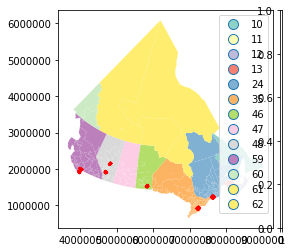

In [10]:
LocationFrame = pd.merge(F_Cities, FSALocates,
                    on='FSA')
LocationFrame = LocationFrame.astype({'Longitude':'float'})
LocationFrame = LocationFrame.astype({'Latitude':'float'})

geometry = [Point(xy) for xy in zip(LocationFrame.Longitude, LocationFrame.Latitude)]
df = LocationFrame.drop(['Longitude','Latitude'], axis=1)
crs = {'init':'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf = gdf.to_crs(epsg=3348)

fp = "lfsa000a16a_e.shp"

map_df = gpd.read_file(fp)
map_df = map_df.set_index('CFSAUID').join(LocationFrame.set_index('FSA'))
map_df = map_df.to_crs({'init': 'epsg:4326'})
map_df = map_df.to_crs(epsg=3348)

fig, ax = plt.subplots(1,1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='1%', pad=0.1)

base = map_df.plot(column='PRUID', cmap='Set3', ax=ax, legend=True);
gdf.plot(ax=base, marker='o', color='red', markersize=5)

As can be seen above, we do see the clusters as desired around the six big Canadian cities. There is a little noise around Vancouver, because of Victoria, Richmond, and Nanaimo all being lumped into the same area, but this is acceptable, when exploring visually, we should see that this does not unduly influence our analysis.

In [15]:
CLIENT_ID='NO3ANLL4454R2C354HVUPP1MFEULGJYCHGXQ3DC4YPG1SSYO'
CLIENT_SECRET='DKQFIGV5DUZJ0LX32G2UZMC1RX34VNJ0FQHTEJKA3GSESLQ5'
VERSION='20191010'
#&ll=40.73,-74.01

LIMIT = 1000

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius = 1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET,         
            lat, lng, 
            VERSION, radius, LIMIT)
        
        results = requests.get(url, verify=False).json() ["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Neighbourhood Latitude', 
                             'Neighbourhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [17]:
CanadaVenues = getNearbyVenues(
    names=LocationFrame['Neighbourhood'],
    latitudes=LocationFrame['Latitude'],
    longitudes=LocationFrame['Longitude'])

Montreal East
Rivière-des-PrairiesNortheast
Rivière-des-PrairiesSouthwest
AnjouEast
MercierWest
MercierSoutheast
Saint-LéonardNorth
Saint-LéonardWest
Saint-LéonardSoutheast
RosemontNorth
Hochelaga
RosemontSouth
Saint-MichelWest
Saint-MichelEast
AhuntsicNorth
VillerayNortheast
Petite-PatrieNortheast
Plateau Mont-RoyalNorth
Plateau Mont-RoyalNorth Central
Centre-SudNorth
AhuntsicEast
AhuntsicSoutheast
VillerayWest
VilleraySoutheast
Plateau Mont-RoyalWest
Outremont
Plateau Mont-RoyalSouth Central
Plateau Mont-RoyalSoutheast
Old Montreal
Downtown MontrealNortheast
Downtown MontrealNorth(McGill University)
Downtown MontrealEast
Downtown MontrealSoutheast (Concordia University)
Downtown MontrealSouthwest
Petite-Bourgogne
Pointe-Saint-Charles
CartiervilleNortheast
Parc-Extension
Mount RoyalNorth
Mount RoyalCentral
Côte-des-NeigesNortheast
Côte-des-NeigesEast
Hampstead / Côte Saint-Luc
WestmountNorth
Notre-Dame-de-GrâceNortheast
Saint-Henri
Ville Émard
VerdunNorth
VerdunSouth
CartiervilleCentr

In [20]:
## This is a backup step, foursquare keeps blocking me, something about pulling so much data down at a time. I've got the
## data, now if I need to work without a fresh pull, this is my checkpoint.
CanadaVenues.to_csv("Amenities.csv")

### Methodology 2 - Amenity Validation

Now that we have all the amenity information around each FSA, the next step is to validate that the information is meaningful... Did the data pull collect information about each community, are the counts different from community to community, and are there a sufficient diversity of amenities that there will be meaningful distinction?  A quick check reveals that there are 14,057 records that have been pulled from foursquare, and there are 418 unique categories. I've demonstrated what those venues are in the following box for thoroughness sake.

In [23]:
print(CanadaVenues.shape)
print('There are {} uniques categories.'.format(len(CanadaVenues['Venue Category'].unique())))
print(CanadaVenues.groupby('Neighbourhood').count())
print(CanadaVenues['Venue Category'].unique())

(14057, 7)
There are 418 uniques categories.
                                   Neighbourhood Latitude  \
Neighbourhood                                               
 Laval-sur-le-Lac                                      10   
Agincourt North                                        15   
AhuntsicEast                                           22   
AhuntsicNorth                                          11   
AhuntsicSoutheast                                      67   
...                                                   ...   
York University                                        24   
citySouth Central                                      12   
citySouthwest Central                                  76   
district municipalityEast Central                       9   
Îles-Laval                                              6   

                                   Neighbourhood Longitude  Venue  \
Neighbourhood                                                       
 Laval-sur-le-Lac      

In [25]:
# One hot encoding transfers all the rows of independent observations (one row per amenity) and converts them into a
# table grouped by a category.  Pretty slick tool that Python (Pandas) has here, it takes a little more shaping in R
# to do this same analysis.

Canada_onehot = pd.get_dummies(CanadaVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Canada_onehot['Neighbourhood'] = CanadaVenues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Canada_onehot.columns[-1]] + list(Canada_onehot.columns[:-1])
Canada_onehot = Canada_onehot[fixed_columns]

Canada_grouped = Canada_onehot.groupby('Neighbourhood').mean().reset_index()
Canada_grouped

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Laval-sur-le-Lac,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,AhuntsicEast,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,AhuntsicNorth,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,AhuntsicSoutheast,0.0,0.0,0.0,0.0,0.0,0.0,0.014925,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.059701,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,York University,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
341,citySouth Central,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
342,citySouthwest Central,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.013158,0.0,0.000000,0.0,0.0,0.0
343,district municipalityEast Central,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.111111,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


### Exploratory Analysis - EDA (1) One-hot Venues

EDA #1 is just a review that the amenities make sense. The above table shows that the one-hot encoding worked and the venues do vary from place to place.  It is amusing that a waterfall is considered a venue.  the next cell below sorts and lists the top 10 venues by community. I won't dig too deeply into this, but just looking between the first two (Laval and Agincourt) we can see that there are similarities and differences.  The number 1 and 2 in Laval (ATM/Gas Station) aren't even in the top 10 for Agincourt, similarly, Agincourt's #1 and #2 (Park/Chinese Restaurant) don't show up in Laval's top 10.  In fact, the only commonality between the two is the #3 (Pharmacy) otherwise the lists are mutually exclusive.

Good confidence that there will be meaningful results.

In [26]:
num_top_venues = 10

for hood in Canada_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Canada_grouped[Canada_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Laval-sur-le-Lac ----
               venue  freq
0                ATM   0.2
1        Gas Station   0.1
2           Pharmacy   0.1
3  Food & Drink Shop   0.1
4       Hockey Arena   0.1
5     Ice Cream Shop   0.1
6      Grocery Store   0.1
7     Sandwich Place   0.1
8        Coffee Shop   0.1
9    Other Nightlife   0.0


----Agincourt North----
                  venue  freq
0                  Park  0.20
1    Chinese Restaurant  0.13
2              Pharmacy  0.13
3                Bakery  0.07
4        Discount Store  0.07
5  Cantonese Restaurant  0.07
6                   Gym  0.07
7             BBQ Joint  0.07
8    Dim Sum Restaurant  0.07
9            Restaurant  0.07


----AhuntsicEast----
                  venue  freq
0           Coffee Shop  0.09
1  Fast Food Restaurant  0.09
2                  Café  0.09
3           Music Store  0.05
4                Office  0.05
5                   Gym  0.05
6         Grocery Store  0.05
7      Sushi Restaurant  0.05
8           Supermarket  0.

                  venue  freq
0                  Park  0.15
1         Grocery Store  0.15
2           Coffee Shop  0.15
3                Bakery  0.08
4           Pizza Place  0.08
5  Fast Food Restaurant  0.08
6        Sandwich Place  0.08
7         Smoothie Shop  0.08
8                  Bank  0.08
9      Sushi Restaurant  0.08


----Central Kitsilano / Greektown----
                           venue  freq
0                    Coffee Shop  0.12
1                         Bakery  0.05
2               Sushi Restaurant  0.04
3                           Café  0.03
4  Vegetarian / Vegan Restaurant  0.03
5                       Tea Room  0.03
6      Middle Eastern Restaurant  0.03
7                 Breakfast Spot  0.03
8                           Park  0.03
9                    Pizza Place  0.03


----Central Londonderry----
                  venue  freq
0  Fast Food Restaurant  0.22
1      Department Store  0.07
2          Liquor Store  0.07
3        Clothing Store  0.07
4           Coffee Sh

                  venue  freq
0  Fast Food Restaurant  0.23
1     Recreation Center  0.08
2             Nightclub  0.08
3                Lounge  0.08
4          Hockey Arena  0.08
5         Luggage Store  0.08
6                   Gym  0.08
7           Coffee Shop  0.08
8        Breakfast Spot  0.08
9      Airport Terminal  0.08


----Douglas Glen / McKenzie Lake / Copperfield / East Shepard----
                           venue  freq
0                   Optical Shop  0.25
1                            Pub  0.25
2              Convenience Store  0.25
3                    Pizza Place  0.25
4                    Other Event  0.00
5                           Park  0.00
6  Paper / Office Supplies Store  0.00
7           Pakistani Restaurant  0.00
8                Paintball Field  0.00
9          Outdoors & Recreation  0.00


----Dovercourt Village----
                   venue  freq
0                   Café  0.10
1                    Bar  0.09
2            Coffee Shop  0.09
3                 Ba

                           venue  freq
0                           Café  0.11
1  Vegetarian / Vegan Restaurant  0.06
2                            Bar  0.06
3                         Bakery  0.05
4             Mexican Restaurant  0.03
5          Vietnamese Restaurant  0.03
6                     Restaurant  0.02
7        Comfort Food Restaurant  0.02
8                           Park  0.02
9                    Coffee Shop  0.02


----Harbourfront----
                venue  freq
0                Park  0.10
1         Coffee Shop  0.08
2             Theater  0.05
3              Bakery  0.05
4  Athletics & Sports  0.03
5                Café  0.03
6              Circus  0.03
7                 Pub  0.03
8           Pet Store  0.02
9        Dessert Shop  0.02


----Harbourfront East----
                 venue  freq
0        Boat or Ferry  0.20
1          Music Venue  0.07
2  Fried Chicken Joint  0.05
3                  Bar  0.05
4              Brewery  0.05
5          Coffee Shop  0.05
6        

9              Pharmacy  0.06


----L'Île-BizardNortheast----
                           venue  freq
0                           Park  0.25
1                   Hockey Arena  0.25
2     Construction & Landscaping  0.25
3             Athletics & Sports  0.25
4                            ATM  0.00
5           Other Great Outdoors  0.00
6                    Pastry Shop  0.00
7  Paper / Office Supplies Store  0.00
8           Pakistani Restaurant  0.00
9                Paintball Field  0.00


----L'Île-BizardSouthwest----
                           venue  freq
0                           Park   0.5
1                    Golf Course   0.5
2                            ATM   0.0
3                   Music School   0.0
4  Paper / Office Supplies Store   0.0
5           Pakistani Restaurant   0.0
6                Paintball Field   0.0
7          Outdoors & Recreation   0.0
8           Outdoor Supply Store   0.0
9              Other Repair Shop   0.0


----LaSalleNorthwest----
                  ven

                           venue  freq
0                 Baseball Field   0.5
1                          Beach   0.5
2                            ATM   0.0
3                    Other Event   0.0
4                           Park   0.0
5  Paper / Office Supplies Store   0.0
6           Pakistani Restaurant   0.0
7                Paintball Field   0.0
8          Outdoors & Recreation   0.0
9           Outdoor Supply Store   0.0


----NW Dunbar-Southlands / Chaldecutt / South University Endowment Lands----
                           venue  freq
0                           Park  0.33
1                          Trail  0.17
2                 Scenic Lookout  0.17
3           Gym / Fitness Center  0.17
4                            Gym  0.17
5                    Pastry Shop  0.00
6  Paper / Office Supplies Store  0.00
7           Pakistani Restaurant  0.00
8                Paintball Field  0.00
9          Outdoors & Recreation  0.00


----NW West End / Stanley Park----
                          

                           venue  freq
0                           Café  0.13
1                            Bar  0.05
2                         Bakery  0.04
3             Mexican Restaurant  0.03
4                    Supermarket  0.03
5  Vegetarian / Vegan Restaurant  0.03
6                  Grocery Store  0.03
7                     Bagel Shop  0.03
8                    Coffee Shop  0.03
9                 Clothing Store  0.03


----Point Douglas East----
               venue  freq
0      Grocery Store  0.11
1      Deli / Bodega  0.11
2  Convenience Store  0.11
3               Café  0.06
4     Sandwich Place  0.06
5         Auditorium  0.06
6   Asian Restaurant  0.06
7        Coffee Shop  0.06
8      Bowling Alley  0.06
9       Burger Joint  0.06


----Point Douglas West / Inkster East----
                  venue  freq
0           Pizza Place  0.17
1  Fast Food Restaurant  0.11
2     Convenience Store  0.06
3                Bakery  0.06
4  Gym / Fitness Center  0.06
5                   G

9           Clothing Store  0.07


----Saint-LaurentInner Northeast----
                       venue  freq
0       Fast Food Restaurant  0.09
1         Italian Restaurant  0.08
2                       Café  0.06
3                   Pharmacy  0.06
4                Pizza Place  0.06
5                Supermarket  0.04
6                Coffee Shop  0.04
7           Sushi Restaurant  0.04
8  Middle Eastern Restaurant  0.04
9               Liquor Store  0.04


----Saint-LaurentOuter Northeast----
                    venue  freq
0  Furniture / Home Store  0.06
1    Fast Food Restaurant  0.06
2          Hardware Store  0.04
3          Sandwich Place  0.04
4                Boutique  0.04
5            Dessert Shop  0.04
6             Coffee Shop  0.04
7          Breakfast Spot  0.04
8          Discount Store  0.04
9           Women's Store  0.04


----Saint-LaurentSoutheast----
                           venue  freq
0                          Hotel  0.15
1                    Coffee Shop  0.15
2 

9            Restaurant  0.07


----Stn A PO Boxes 25 The Esplanade----
                 venue  freq
0          Coffee Shop  0.09
1                 Café  0.08
2                Hotel  0.06
3           Restaurant  0.05
4   Italian Restaurant  0.04
5           Steakhouse  0.03
6  Japanese Restaurant  0.03
7                 Park  0.03
8   Seafood Restaurant  0.03
9             Beer Bar  0.03


----Strathcona / Chinatown / Downtown Eastside----
                venue  freq
0                Café  0.07
1         Coffee Shop  0.05
2  Chinese Restaurant  0.05
3          Restaurant  0.04
4              Lounge  0.03
5            Beer Bar  0.03
6         Pizza Place  0.03
7  Mexican Restaurant  0.03
8  Seafood Restaurant  0.03
9    Asian Restaurant  0.03


----Studio District----
                   venue  freq
0            Coffee Shop  0.08
1                 Bakery  0.06
2                    Bar  0.06
3  Vietnamese Restaurant  0.05
4     Italian Restaurant  0.04
5                   Café  0.04
6    

9  Pakistani Restaurant  0.00


----Victoria Hotel----
                 venue  freq
0          Coffee Shop  0.11
1                 Café  0.07
2                Hotel  0.06
3            Gastropub  0.03
4  American Restaurant  0.03
5         Concert Hall  0.03
6             Beer Bar  0.03
7           Restaurant  0.03
8  Japanese Restaurant  0.03
9   Italian Restaurant  0.02


----Victoria Village----
                 venue  freq
0          Pizza Place  0.09
1          Coffee Shop  0.09
2          Men's Store  0.04
3         Hockey Arena  0.04
4            BBQ Joint  0.04
5             Pharmacy  0.04
6    Martial Arts Dojo  0.04
7  Sporting Goods Shop  0.04
8  Rental Car Location  0.04
9       Sandwich Place  0.04


----Ville Saint-Pierre----
                   venue  freq
0            Pizza Place  0.29
1   Fast Food Restaurant  0.14
2          Train Station  0.14
3               Pharmacy  0.14
4          Grocery Store  0.14
5                   Café  0.14
6                    ATM  0.00
7  

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Canada_grouped['Neighbourhood']

for ind in np.arange(Canada_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Canada_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Laval-sur-le-Lac,ATM,Ice Cream Shop,Gas Station,Sandwich Place,Pharmacy,Hockey Arena,Coffee Shop,Food & Drink Shop,Grocery Store,Factory
1,Agincourt North,Park,Chinese Restaurant,Pharmacy,BBQ Joint,Bakery,Cantonese Restaurant,Restaurant,Discount Store,Shopping Mall,Gym
2,AhuntsicEast,Café,Fast Food Restaurant,Coffee Shop,Pub,Athletics & Sports,Music Store,Soccer Stadium,Business Service,Supermarket,Sushi Restaurant
3,AhuntsicNorth,Grocery Store,Pet Store,Fast Food Restaurant,Dry Cleaner,Gas Station,Pharmacy,Vietnamese Restaurant,Café,Convenience Store,Italian Restaurant
4,AhuntsicSoutheast,Coffee Shop,Sporting Goods Shop,Sandwich Place,Women's Store,Fast Food Restaurant,Furniture / Home Store,Italian Restaurant,Discount Store,Breakfast Spot,Boutique
5,Albion Gardens,Grocery Store,Pizza Place,Sushi Restaurant,Pharmacy,Sandwich Place,Coffee Shop,Fast Food Restaurant,Hardware Store,Beer Store,Electronics Store
6,Alderwood,Pharmacy,Pizza Place,Coffee Shop,Convenience Store,Bar,Park,Gym,Grocery Store,Greek Restaurant,Burger Joint
7,AnjouEast,Pharmacy,Convenience Store,Park,Supermarket,Gym / Fitness Center,BBQ Joint,Fast Food Restaurant,Pizza Place,Soccer Field,Hockey Arena
8,Assiniboine South / Betsworth,Business Service,Pizza Place,Construction & Landscaping,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival
9,AuteuilSouth,Event Service,Gym,Music Venue,Park,Film Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market


### EDA (2) - Wordy Venues

This is a really powerful table that shows the different venues for the first ten communities. What I find most fascinating about this is how unique they all are. We don't see the same two things in a row for any of the choices. Even in Ahuntsic, which is thrice represented here, the amenities are quite distinct. If we see regional trends, they will certainly have a high hurdle to clear.

In [203]:
# set number of clusters
kclusters = 5
RSS=3425

Canada_grouped_clustering = Canada_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=RSS).fit(Canada_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:400] )

print(Counter(kmeans.labels_))

[3 0 2 3 2 3 3 3 4 0 2 2 2 2 3 2 2 0 2 0 2 2 2 2 2 3 3 0 0 2 2 2 3 3 2 1 2
 2 2 2 2 3 3 2 2 2 2 2 3 0 2 2 2 2 2 3 0 2 2 2 2 2 2 2 1 0 1 3 2 0 2 2 2 3
 2 2 2 2 2 2 4 3 3 2 3 2 0 2 2 2 2 2 2 2 2 2 2 2 4 1 2 2 2 2 2 2 2 2 3 2 3
 2 2 2 2 1 3 2 2 2 2 3 2 3 3 3 1 3 2 2 2 2 2 2 2 2 0 0 3 4 0 3 2 2 2 3 2 2
 2 3 1 2 0 2 2 1 2 0 3 2 2 2 3 2 2 1 2 2 1 3 2 2 2 2 2 2 0 2 2 2 1 2 2 0 2
 2 1 2 2 2 0 2 2 2 2 2 2 2 2 3 2 2 3 0 2 2 2 2 2 2 2 3 3 2 2 1 0 3 2 2 2 3
 4 4 2 0 3 2 1 0 2 2 3 2 2 2 2 2 2 2 2 2 3 2 0 2 2 2 2 1 3 2 3 2 3 2 2 3 2
 3 2 1 3 0 0 3 2 2 2 2 2 0 3 1 2 2 2 3 2 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 2 2 3 2 2 2 2 1 2 1 2 2 2 2 0 2 0 2 2 2 3 2 2 2 2 3 1 0 2 2 2 1 2 2 1
 2 3 2 0 2 2 0 3 0 2 0 2]
Counter({2: 222, 3: 60, 0: 35, 1: 22, 4: 6})


In [204]:
# add clustering labels
# neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
if 'Cluster Labels' in neighbourhoods_venues_sorted:
    del neighbourhoods_venues_sorted['Cluster Labels']
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [205]:
Canada_merged = LocationFrame

# merge canada_grouped with canada_data to add latitude/longitude for each neighbourhood
Canada_merged = Canada_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
Canada_merged.drop(Canada_merged[Canada_merged['Neighbourhood'] == "Not assigned"].index, inplace=True)
Canada_merged.dropna(inplace=True)
Canada_merged.columns = ['FSA','Neighbourhood','City','Longitude','Latitude','ClusterLabels','1stCommonVenue',
                        '2ndCommonVenue','3rdCommonVenue','4thCommonVenue','5thCommonVenue','6thCommonVenue',
                         '7thCommonVenue','8thCommonVenue','9thCommonVenue','10thCommonVenue']
#Canada_merged.drop(Canada_merged[Canada_merged['ClusterLabels'] == "NaN"].index, inplace=True)
Canada_merged.tail(60)


,FSA,Neighbourhood,City,Longitude,Latitude,ClusterLabels,1stCommonVenue,2ndCommonVenue,3rdCommonVenue,4thCommonVenue,5thCommonVenue,6thCommonVenue,7thCommonVenue,8thCommonVenue,9thCommonVenue,10thCommonVenue
290,T2Z,Douglas Glen / McKenzie Lake / Copperfield / E...,Calgary,-113.985382,50.937796,3.0,Pub,Pizza Place,Convenience Store,Optical Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
291,T3B,Montgomery / Bowness / Silver Springs / Greenwood,Calgary,-114.192554,51.084066,2.0,Coffee Shop,Stadium,Hotel,Café,Food & Drink Shop,Garden Center,Arts & Crafts Store,Home Service,Vietnamese Restaurant,Pub
292,T3G,Hawkwood / Arbour Lake / Citadel / Ranchlands ...,Calgary,-114.213676,51.151886,3.0,Coffee Shop,Pub,Fast Food Restaurant,Pharmacy,Burger Joint,Miscellaneous Shop,Gas Station,Sandwich Place,Park,Breakfast Spot
293,T3K,Sandstone / MacEwan Glen / Beddington / Harves...,Calgary,-114.059753,51.158176,3.0,Grocery Store,Fast Food Restaurant,Coffee Shop,Gym,Pizza Place,American Restaurant,Paper / Office Supplies Store,Sandwich Place,Bakery,Bank
294,T3L,Tuscany / Scenic Acres,Calgary,-114.238095,51.109460,1.0,Fast Food Restaurant,Event Space,Coffee Shop,Trail,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Festival
295,T3M,Cranston / Auburn Bay / Mahogany,Calgary,-114.089532,51.003521,2.0,Dog Run,Restaurant,Coffee Shop,Food & Drink Shop,Park,Clothing Store,Wine Shop,Ice Cream Shop,Golf Course,Shopping Mall
296,T5A,West Clareview / East Londonderry,Edmonton,-113.405289,53.586708,1.0,Fast Food Restaurant,Pharmacy,Miscellaneous Shop,Bakery,Sandwich Place,Shopping Mall,Coffee Shop,Asian Restaurant,Café,Greek Restaurant
297,T5B,East North Central / West Beverly,Edmonton,-113.461647,53.571335,2.0,Bakery,Hockey Arena,Grocery Store,Bar,Burger Joint,Sandwich Place,Casino,Fast Food Restaurant,Coffee Shop,Latin American Restaurant
298,T5C,Central Londonderry,Edmonton,-113.453545,53.601643,1.0,Fast Food Restaurant,Liquor Store,Department Store,Clothing Store,Coffee Shop,Sporting Goods Shop,Sandwich Place,Gym / Fitness Center,American Restaurant,Thai Restaurant
299,T5E,West Londonderry / East Calder,Edmonton,-113.497437,53.593513,2.0,Coffee Shop,Fast Food Restaurant,Hotel,Sandwich Place,Dessert Shop,Pharmacy,Sports Bar,Hobby Shop,Mexican Restaurant,Furniture / Home Store


In [206]:
Canada_merged.loc[Canada_merged['ClusterLabels'] == 0, Canada_merged.columns[[0] + list(range(2, Canada_merged.shape[1]))]]

,FSA,City,Longitude,Latitude,ClusterLabels,1stCommonVenue,2ndCommonVenue,3rdCommonVenue,4thCommonVenue,5thCommonVenue,6thCommonVenue,7thCommonVenue,8thCommonVenue,9thCommonVenue,10thCommonVenue
36,H3M,Montreal,-73.694664,45.539429,0.0,Park,Pharmacy,Paper / Office Supplies Store,Bookstore,Gym,Sandwich Place,Shopping Mall,Coffee Shop,Asian Restaurant,Middle Eastern Restaurant
41,H3V,Montreal,-73.608086,45.499496,0.0,Park,Bakery,Coffee Shop,Scenic Lookout,Convenience Store,Bus Station,Hotel,Skating Rink,Event Space,Exhibit
48,H4H,Montreal,-73.589352,45.443691,0.0,Park,Liquor Store,Convenience Store,Smoke Shop,Metro Station,Diner,Botanical Garden,Grocery Store,Coffee Shop,Farmers Market
50,H4K,Montreal,-73.742253,45.518358,0.0,Park,Empada House,Pharmacy,Mediterranean Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
55,H4R,Montreal,-73.711639,45.508213,0.0,Park,Skating Rink,Pizza Place,Café,Sporting Goods Shop,Gas Station,Convenience Store,Garden Center,Athletics & Sports,Soccer Field
68,H7K,Montreal,-73.727585,45.630966,0.0,Event Service,Gym,Music Venue,Park,Film Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
83,H8Y,Montreal,-73.805191,45.510863,0.0,Park,Grocery Store,Train Station,Jewelry Store,Zoo Exhibit,Filipino Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant
87,H9E,Montreal,-73.894131,45.487076,0.0,Park,Golf Course,Fountain,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
90,H9J,Montreal,-73.874672,45.446732,0.0,Park,Furniture / Home Store,Baseball Field,Soccer Field,Film Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
91,H9K,Montreal,-73.915878,45.459637,0.0,Park,Other Repair Shop,Bus Stop,Film Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [207]:
Canada_merged.loc[Canada_merged['ClusterLabels'] == 1, Canada_merged.columns[[0] + list(range(2, Canada_merged.shape[1]))]]

,FSA,City,Longitude,Latitude,ClusterLabels,1stCommonVenue,2ndCommonVenue,3rdCommonVenue,4thCommonVenue,5thCommonVenue,6thCommonVenue,7thCommonVenue,8thCommonVenue,9thCommonVenue,10thCommonVenue
0,H1B,Montreal,-73.524467,45.639336,1.0,Coffee Shop,Auto Garage,Gas Station,Electronics Store,Zoo Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
5,H1N,Montreal,-73.528831,45.578129,1.0,Coffee Shop,Liquor Store,Pool,Fast Food Restaurant,Restaurant,Big Box Store,Park,Field,Event Service,Event Space
56,H4S,Montreal,-73.746414,45.493683,1.0,Automotive Shop,Market,Fast Food Restaurant,Coffee Shop,Zoo Exhibit,Film Studio,Factory,Falafel Restaurant,Farm,Farmers Market
67,H7G,Montreal,-73.683708,45.581810,1.0,Supermarket,Breakfast Spot,Fast Food Restaurant,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Festival,Field
92,H9P,Montreal,-73.779259,45.474304,1.0,Fast Food Restaurant,Breakfast Spot,Furniture / Home Store,Lounge,Gym,Coffee Shop,Hockey Arena,Nightclub,Luggage Store,Airport Terminal
96,M1B,Toronto,-79.193321,43.809444,1.0,Zoo Exhibit,Coffee Shop,Fast Food Restaurant,Spa,Trail,Hobby Shop,Business Service,Exhibit,Factory,Falafel Restaurant
97,M1B,Toronto,-79.193321,43.809444,1.0,Zoo Exhibit,Coffee Shop,Fast Food Restaurant,Spa,Trail,Hobby Shop,Business Service,Exhibit,Factory,Falafel Restaurant
104,M1J,Toronto,-79.231232,43.745644,1.0,Fast Food Restaurant,Sandwich Place,Big Box Store,Restaurant,Park,Indian Restaurant,Chinese Restaurant,Train Station,Convenience Store,Coffee Shop
113,M1P,Toronto,-79.269905,43.762722,1.0,Electronics Store,Coffee Shop,Park,Furniture / Home Store,Fast Food Restaurant,Pizza Place,Automotive Shop,Indian Restaurant,Pet Store,Wings Joint
114,M1P,Toronto,-79.269905,43.762722,1.0,Electronics Store,Coffee Shop,Park,Furniture / Home Store,Fast Food Restaurant,Pizza Place,Automotive Shop,Indian Restaurant,Pet Store,Wings Joint


In [208]:
Canada_merged.loc[Canada_merged['ClusterLabels'] == 2, Canada_merged.columns[[0] + list(range(2, Canada_merged.shape[1]))]]

,FSA,City,Longitude,Latitude,ClusterLabels,1stCommonVenue,2ndCommonVenue,3rdCommonVenue,4thCommonVenue,5thCommonVenue,6thCommonVenue,7thCommonVenue,8thCommonVenue,9thCommonVenue,10thCommonVenue
4,H1M,Montreal,-73.553711,45.590820,2.0,Liquor Store,Fast Food Restaurant,Sandwich Place,Pizza Place,Park,Pharmacy,Supermarket,Bookstore,Restaurant,Martial Arts Dojo
8,H1S,Montreal,-73.580460,45.583973,2.0,Hotel,Coffee Shop,Pharmacy,Sandwich Place,Fast Food Restaurant,Bakery,Bike Shop,Gastropub,Restaurant,Furniture / Home Store
10,H1W,Montreal,-73.547729,45.543690,2.0,Restaurant,Pharmacy,Bar,Coffee Shop,Park,Fast Food Restaurant,French Restaurant,Supermarket,Tex-Mex Restaurant,Bakery
11,H1Y,Montreal,-73.581306,45.549854,2.0,Pharmacy,Bar,Breakfast Spot,Fast Food Restaurant,Park,Café,Diner,Bakery,Grocery Store,Italian Restaurant
13,H2A,Montreal,-73.597984,45.563271,2.0,Vietnamese Restaurant,Pharmacy,Coffee Shop,Liquor Store,Sandwich Place,Supermarket,Fried Chicken Joint,Automotive Shop,Metro Station,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,V8V,Victoria,-123.366241,48.417934,2.0,Coffee Shop,Hotel,Bakery,American Restaurant,Café,Bar,Pub,Cocktail Bar,Asian Restaurant,Sushi Restaurant
350,V8W,Victoria,-123.363647,48.426025,2.0,Coffee Shop,Restaurant,Breakfast Spot,Vegetarian / Vegan Restaurant,Hotel,Tea Room,Plaza,Japanese Restaurant,American Restaurant,Tapas Restaurant
351,V8Y,Victoria,-123.375145,48.540497,2.0,Baseball Field,Beach,Zoo Exhibit,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field
352,V9A,Victoria,-123.419521,48.438397,2.0,Gym / Fitness Center,Restaurant,Skating Rink,Coffee Shop,Café,Pizza Place,Grocery Store,Motorsports Shop,Breakfast Spot,Fondue Restaurant


In [209]:
Canada_merged.loc[Canada_merged['ClusterLabels'] == 3, Canada_merged.columns[[0] + list(range(2, Canada_merged.shape[1]))]]

,FSA,City,Longitude,Latitude,ClusterLabels,1stCommonVenue,2ndCommonVenue,3rdCommonVenue,4thCommonVenue,5thCommonVenue,6thCommonVenue,7thCommonVenue,8thCommonVenue,9thCommonVenue,10thCommonVenue
3,H1K,Montreal,-73.544495,45.611286,3.0,Pharmacy,Convenience Store,Park,Supermarket,Gym / Fitness Center,BBQ Joint,Fast Food Restaurant,Pizza Place,Soccer Field,Hockey Arena
6,H1P,Montreal,-73.595184,45.599487,3.0,Bakery,Home Service,Sports Bar,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Sandwich Place,Pharmacy
7,H1R,Montreal,-73.612091,45.588356,3.0,Bank,Grocery Store,Convenience Store,Ice Cream Shop,Pharmacy,Gas Station,Fast Food Restaurant,Video Store,Filipino Restaurant,Exhibit
9,H1T,Montreal,-73.567345,45.570187,3.0,Grocery Store,Bus Stop,Park,Gym / Fitness Center,Scenic Lookout,Golf Course,Fast Food Restaurant,Pharmacy,Coffee Shop,Food Truck
12,H1Z,Montreal,-73.619865,45.572300,3.0,Grocery Store,Fast Food Restaurant,Department Store,Pharmacy,Cajun / Creole Restaurant,Discount Store,Clothing Store,Zoo Exhibit,Film Studio,Falafel Restaurant
14,H2B,Montreal,-73.656509,45.580210,3.0,Grocery Store,Pet Store,Fast Food Restaurant,Dry Cleaner,Gas Station,Pharmacy,Vietnamese Restaurant,Café,Convenience Store,Italian Restaurant
49,H4J,Montreal,-73.711548,45.532181,3.0,Coffee Shop,Fast Food Restaurant,Grocery Store,Sports Bar,Dim Sum Restaurant,Sushi Restaurant,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Pharmacy
58,H4V,Montreal,-73.646759,45.468731,3.0,Pizza Place,Ice Cream Shop,Korean Restaurant,Liquor Store,Discount Store,Intersection,Pharmacy,Burger Joint,Shopping Mall,Coffee Shop
64,H7B,Montreal,-73.670334,45.615640,3.0,Grocery Store,Chocolate Shop,Ice Cream Shop,Pharmacy,Fast Food Restaurant,Coffee Shop,Park,Zoo Exhibit,Festival,Event Space
70,H7M,Montreal,-73.718102,45.600834,3.0,Pharmacy,Fast Food Restaurant,Grocery Store,Restaurant,Bakery,Convenience Store,Breakfast Spot,Pizza Place,Diner,Skating Rink


In [210]:
Canada_merged.loc[Canada_merged['ClusterLabels'] == 4, Canada_merged.columns[[0] + list(range(2, Canada_merged.shape[1]))]]

,FSA,City,Longitude,Latitude,ClusterLabels,1stCommonVenue,2ndCommonVenue,3rdCommonVenue,4thCommonVenue,5thCommonVenue,6thCommonVenue,7thCommonVenue,8thCommonVenue,9thCommonVenue,10thCommonVenue
1,H1C,Montreal,-73.538952,45.674368,4.0,Park,Construction & Landscaping,Film Studio,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
2,H1E,Montreal,-73.596031,45.649031,4.0,Construction & Landscaping,Park,Ice Cream Shop,Film Studio,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
66,H7E,Montreal,-73.682487,45.629631,4.0,Construction & Landscaping,Garden Center,Zoo Exhibit,Financial or Legal Service,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
86,H9C,Montreal,-73.881348,45.505299,4.0,Park,Construction & Landscaping,Athletics & Sports,Hockey Arena,Filipino Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm
277,R3R,Winnipeg,-97.286888,49.849773,4.0,Business Service,Pizza Place,Construction & Landscaping,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival
281,T2B,Calgary,-113.957993,51.024666,4.0,Convenience Store,Construction & Landscaping,Liquor Store,Skating Rink,Park,Filipino Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant


In [211]:
LocationFrame
newMap_df = map_df
newMap_df = newMap_df.reset_index()
newMap_df.columns = ['FSA','PRUID','Province','geometry','Neighbourhood','City','Longitude','Latitude']
newMap_df

,FSA,PRUID,Province,geometry,Neighbourhood,City,Longitude,Latitude
0,A0A,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,(POLYGON ((8965891.222856071 2153384.774283481...,NaN,NaN,NaN,NaN
1,A0B,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,(POLYGON ((8926601.957145995 2180310.531428572...,NaN,NaN,NaN,NaN
2,A0C,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,(POLYGON ((8905299.005715933 2221132.305713665...,NaN,NaN,NaN,NaN
3,A0E,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,"POLYGON ((8909455.542855999 2162746.719998556,...",NaN,NaN,NaN,NaN
4,A0G,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,"POLYGON ((8816520.788570749 2335270.254283929,...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1688,X0G,61,Northwest Territories / Territoires du Nord-Ouest,"POLYGON ((4569793.422854936 3068648.757144879,...",NaN,NaN,NaN,NaN
1689,X1A,61,Northwest Territories / Territoires du Nord-Ouest,"POLYGON ((5152711.728569978 3110701.174284935,...",NaN,NaN,NaN,NaN
1690,Y0A,60,Yukon,"POLYGON ((4463431.114284976 3683146.831429968,...",NaN,NaN,NaN,NaN
1691,Y0B,60,Yukon,(POLYGON ((4561932.471429996 4312865.174284995...,NaN,NaN,NaN,NaN


In [217]:
CanMap_df = newMap_df.merge(Canada_merged, on='FSA')

Vancouver = CanMap_df[CanMap_df['City_x'] == 'Vancouver']
Calgary = CanMap_df[CanMap_df['City_x'] == 'Calgary']
Edmonton = CanMap_df[CanMap_df['City_x'] == 'Edmonton']
Winnipeg = CanMap_df[CanMap_df['City_x'] == 'Winnipeg']
Toronto = CanMap_df[CanMap_df['City_x'] == 'Toronto']
Montreal = CanMap_df[CanMap_df['City_x'] == 'Montreal']

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size='5%', pad=0.1)

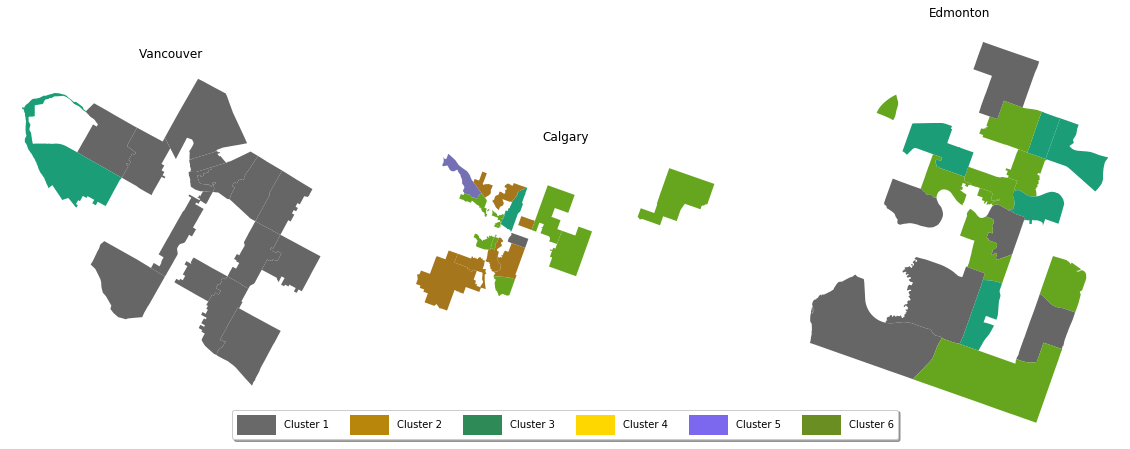

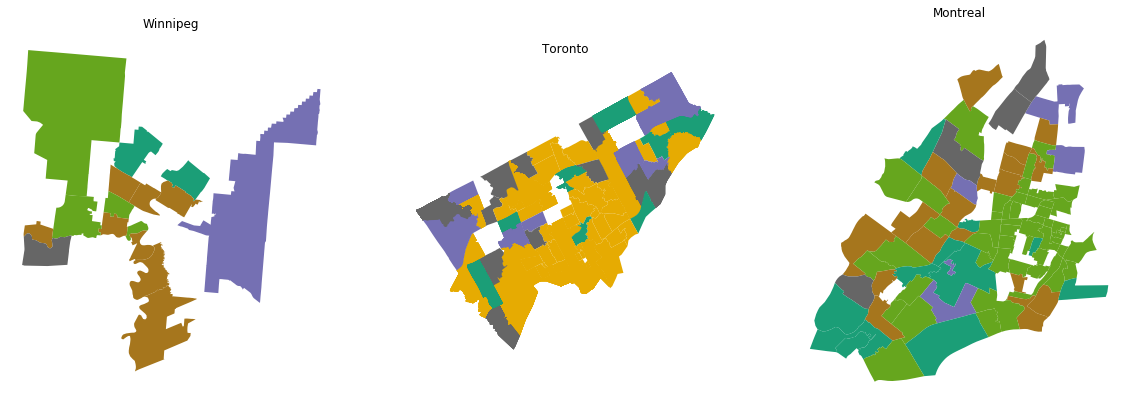

In [250]:
from matplotlib.patches import Patch
legend_elements =[Patch(facecolor='dimgrey', edgecolor='white', label='Cluster 1'),
                 Patch(facecolor='darkgoldenrod', edgecolor='white', label='Cluster 2'),
                 Patch(facecolor='seagreen', edgecolor='white', label='Cluster 3'),
                 Patch(facecolor='gold', edgecolor='white', label='Cluster 4'),
                 Patch(facecolor='mediumslateblue', edgecolor='white', label='Cluster 5'),
                 Patch(facecolor='olivedrab', edgecolor='white', label='Cluster 6')]

fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharex=False, sharey=False, figsize=(20,20))
Vancouver.plot(column='ClusterLabels', cmap='Dark2', ax=ax1, legend=False);
Calgary.plot(column='ClusterLabels', cmap='Dark2', ax=ax2, legend=False);
Edmonton.plot(column='ClusterLabels', cmap='Dark2', ax=ax3, legend=False);
ax1.axis('off'), ax2.axis('off'), ax3.axis('off')
ax1.set_title('Vancouver'), ax2.set_title('Calgary'), ax3.set_title('Edmonton')
fig, (ax4, ax5,ax6) = plt.subplots(ncols=3, sharex=False, sharey=False, figsize=(20,20))
Winnipeg.plot(column='ClusterLabels', cmap='Dark2', ax=ax4, legend=False);
Toronto.plot(column='ClusterLabels', cmap='Dark2', ax=ax5, legend=False);
Montreal.plot(column='ClusterLabels', cmap='Dark2', ax=ax6, legend=False);
ax4.axis('off'), ax5.axis('off'), ax6.axis('off')
ax4.set_title('Winnipeg'), ax5.set_title('Toronto'), ax6.set_title('Montreal')

ax2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5,-0.5), fancybox=True, shadow=True, ncol=6,
          handlelength=4, handleheight=3)
plt.show()

### Results
The six figures above comprise the primary findings of this assignment. Six different maps have been created showing the cities and their cluster distributions.  
- Vancouver is almost entirely assigned to Cluster 1
- Calgary is split between Clusters 2 and 6 
- Edmonton is split between Clusters 1, 3, and 6. 
- Winnipeg is mostly Cluster 2. 
- Toronto is primarily Cluster 4, with some Clusters 1 and 5. 
- Montreal is a patchwork of Cluster 2, 3, and 6.

Toronto is the only city with any of Cluster 4, and it is the dominant cluster. Vancouver is a nearly uniform Cluster 1, while Calgary, Edmonton, Winnipeg, and Montreal are more mixed.

### Discussion

The question presented asked if Canadian cities are homogenous entities, indistinguishable from one another based on their venue availability. The analysis suggests that this is not the case. While it is not determinable whether regional tendency or unique urban criteria describe it, it is clear that Canadian cities are clearly unique and distinct from one another.

Vancouver and Toronto are quite different from one another, but within each of them, they are nearly uniform in terms of what services and amenities are available to the citizens. Montreal has a patchwork of various types of amenities that varies greatly from neighbourhood to neighbourhood. Calgary and Winnipeg share a similar distribution of amenities while Edmonton looks like it is partway between its prairie neighbours (Calgary and Winnipeg) and Vancouver to the West.

Referring to the expected regionality. If clusters were to be applied to the cities themselves, it is likely that the expected regions would appear if we were to create four clusters:
- Vancouver (West Coast)
- Calgary, Edmonton, Winnipeg (Prairies)
- Toronto
- Montreal

It is interesting to note that despite similar needs, and even similar ethnic, gender, and age characteristics, regional trends influence service availability in each city.

### Conclusion

Those services that are available to citizens of Canadian cities vary by region. Cities within the same region demonstrate more similar characteristics, and great consistency within themselves, while cities between region show different characteristics.  A city may in itself be a pretty consistent, sterile environment, but travelling between Canadian cities will provide a variety of experiences.  For politicians, it can probably be concluded that the message needs to be modified for each unique place.